In [14]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', size=18)

In [15]:
nano_df = []
for nano_baby in glob.glob("output/ttbar-monolep*"):
    nano_df.append(((uproot.open(nano_baby)).get("tree")).pandas.df())
nano_df = pd.concat(nano_df)

## 1. Sanity Checks

In [16]:
nano_df.columns

Index([u'event', u'ht', u'met', u'deepCSV_btags_loose',
       u'deepCSV_btags_medium', u'deepCSV_btags_tight', u'deepJet_btags_loose',
       u'deepJet_btags_medium', u'deepJet_btags_tight', u'lepton_id',
       u'lepton_pt', u'lepton_pt_corr', u'lepton_eta', u'lepton_phi',
       u'fake_id', u'fake_pt', u'fake_pt_corr', u'fake_eta', u'fake_phi',
       u'fake_unmatched', u'fake_from_b', u'fake_from_c', u'fake_from_light'],
      dtype='object')

In [17]:
fake_els_df = nano_df[nano_df.fake_id.abs() == 11] # Tight single-muon events w/ tight fake electron
fake_mus_df = nano_df[nano_df.fake_id.abs() == 13] # Tight single-muon events w/ tight fake electron

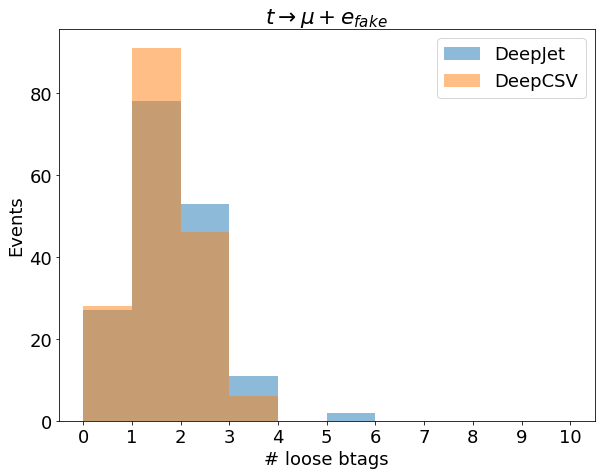

In [18]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.deepJet_btags_loose, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepJet");
plt.hist(fake_els_df.deepCSV_btags_loose, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepCSV");

plt.legend();
plt.title(r"$t\rightarrow \mu+e_{fake}$");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel("# loose btags");
plt.ylabel("Events");

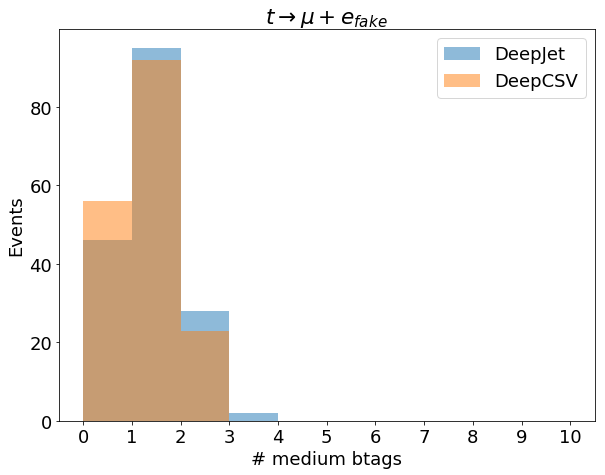

In [19]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.deepJet_btags_medium, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepJet");
plt.hist(fake_els_df.deepCSV_btags_medium, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepCSV");

plt.legend();
plt.title(r"$t\rightarrow \mu+e_{fake}$");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel("# medium btags");
plt.ylabel("Events");

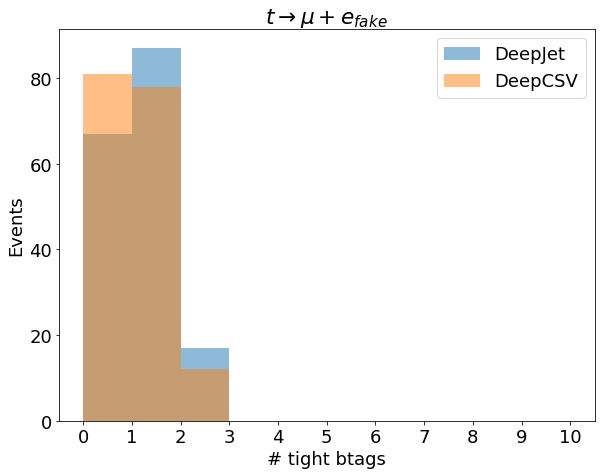

In [20]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.deepJet_btags_tight, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepJet");
plt.hist(fake_els_df.deepCSV_btags_tight, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepCSV");

plt.legend();
plt.title(r"$t\rightarrow \mu+e_{fake}$");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel("# tight btags");
plt.ylabel("Events");

## 2. Plots

In [21]:
def lineage_hist(df, n_btags, algo, wp,
                 fig=None, axes=None, fmt="bo", label="",
                 b_text=True):
    if not fig or not axes:
        fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
        axes = plt.subplot(111)
    # Bin sizes
    bin_edges = np.arange(5)[1:]
    bin_widths = bin_edges[1:]-bin_edges[:-1]
    bin_centers = bin_edges[:-1]+0.5*bin_widths
    # Bin values
    bin_vals = np.zeros(4)
    deepalgo_btags = df["{0}_btags_{1}".format(algo, wp)]
    bin_vals[0] = np.sum(df[deepalgo_btags >= n_btags].fake_from_c)
    bin_vals[1] = np.sum(df[deepalgo_btags >= n_btags].fake_from_b)
    bin_vals[2] = np.sum(df[deepalgo_btags >= n_btags].fake_from_light)
    bin_vals[3] = np.sum(df[deepalgo_btags >= n_btags].fake_unmatched)
    # Plot
    axes.errorbar(bin_edges, bin_vals, xerr=0.5, fmt=fmt, label=label);
    # Marker labels
    if b_text:
        count = int(bin_vals[1]) # bin count for 'from b' bin
        plt.text(2, count+1, # x=2 <--> from b, y=count+1 gives small padding
                 "{0:#d} ({1:0.1f})%".format(count, 100.0*count/np.sum(bin_vals)),
                 horizontalalignment='center')
    # Plot formatting
    plt.xticks(bin_edges, ["c", "b", "light/other", "unmatched"]);
    plt.ylabel("Events");
    plt.grid()

## 3. Fake electrons
From several samples of single-lepton $t\bar{t}$, where we require (at the generator level) $t\rightarrow W\rightarrow \mu$, i.e. we truth match to a single-muon event, then require both a tight $\mu$ (prompt) and a tight $e$ (non-prompt) in reco.

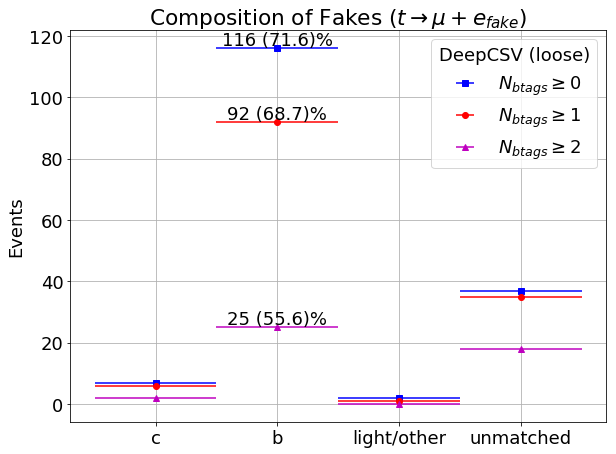

In [22]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

lineage_hist(fake_els_df, n_btags=0, algo="deepCSV", wp="loose",
             fig=fig, axes=axes, fmt="bs", label=r"$N_{btags}\geq 0$")
lineage_hist(fake_els_df, n_btags=1, algo="deepCSV", wp="loose",
             fig=fig, axes=axes, fmt="ro", label=r"$N_{btags}\geq 1$")
lineage_hist(fake_els_df, n_btags=2, algo="deepCSV", wp="loose",
             fig=fig, axes=axes, fmt="m^", label=r"$N_{btags}\geq 2$")

plt.title(r"Composition of Fakes ($t\rightarrow \mu+e_{fake}$)");
plt.legend(title="DeepCSV (loose)");

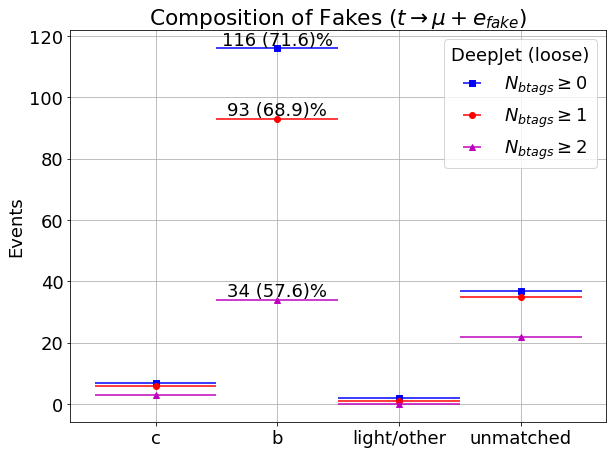

In [23]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

lineage_hist(fake_els_df, n_btags=0, algo="deepJet", wp="loose",
             fig=fig, axes=axes, fmt="bs", label=r"$N_{btags}\geq 0$")
lineage_hist(fake_els_df, n_btags=1, algo="deepJet", wp="loose",
             fig=fig, axes=axes, fmt="ro", label=r"$N_{btags}\geq 1$")
lineage_hist(fake_els_df, n_btags=2, algo="deepJet", wp="loose",
             fig=fig, axes=axes, fmt="m^", label=r"$N_{btags}\geq 2$")

plt.title(r"Composition of Fakes ($t\rightarrow \mu+e_{fake}$)");
plt.legend(title="DeepJet (loose)");

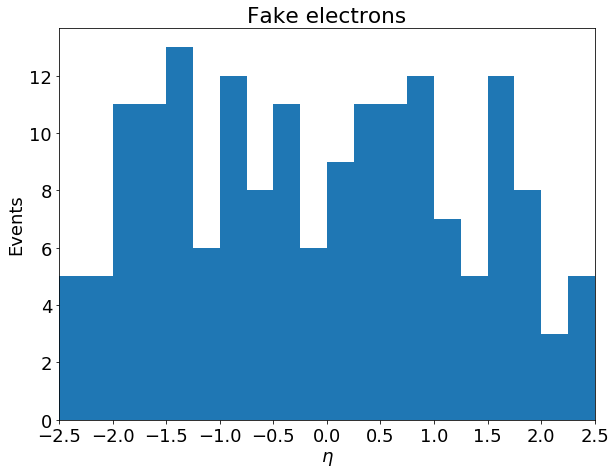

In [24]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.fake_eta, bins=np.linspace(-2.5,2.5,21));

plt.title("Fake electrons")
plt.xticks(np.linspace(-2.5,2.5,11));
plt.xlabel(r"$\eta$")
plt.ylabel("Events")
axes.margins(x=0) # Remove x-axis margins

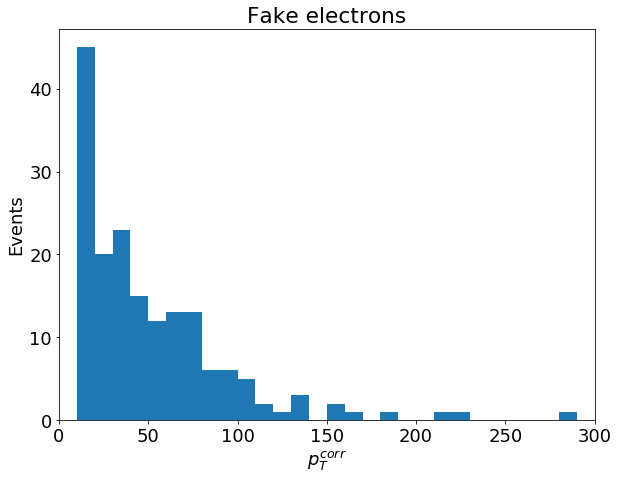

In [31]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.fake_pt_corr, bins=np.linspace(0,300,31));

plt.title("Fake electrons")
# plt.xticks(np.linspace(-2.5,2.5,11));
plt.xlabel(r"$p_{T}^{corr}$")
plt.ylabel("Events")
axes.margins(x=0) # Remove x-axis margins

## 4. Fake muons
From several samples of single-lepton $t\bar{t}$, where we require (at the generator level) $t\rightarrow W\rightarrow e$, i.e. we truth match to a single-electron event, then require both a tight $e$ (prompt) and a tight $\mu$ (non-prompt) in reco.

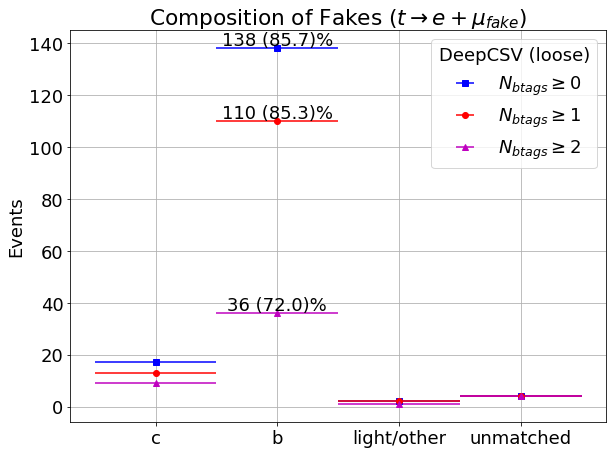

In [26]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

lineage_hist(fake_mus_df, n_btags=0, algo="deepCSV", wp="loose",
             fig=fig, axes=axes, fmt="bs", label=r"$N_{btags}\geq 0$")
lineage_hist(fake_mus_df, n_btags=1, algo="deepCSV", wp="loose",
             fig=fig, axes=axes, fmt="ro", label=r"$N_{btags}\geq 1$")
lineage_hist(fake_mus_df, n_btags=2, algo="deepCSV", wp="loose",
             fig=fig, axes=axes, fmt="m^", label=r"$N_{btags}\geq 2$")

plt.title(r"Composition of Fakes ($t\rightarrow e+\mu_{fake}$)");
plt.legend(title="DeepCSV (loose)");

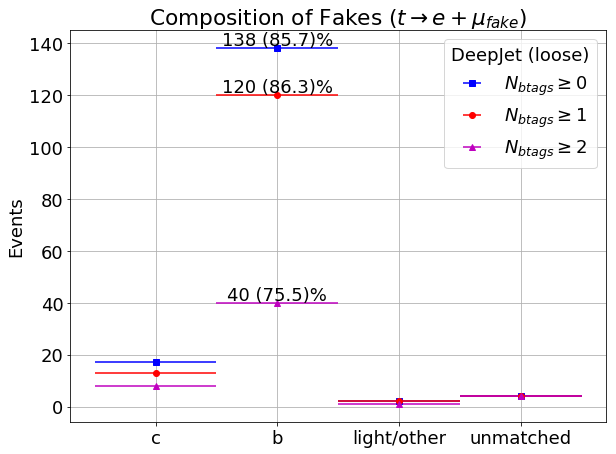

In [27]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

lineage_hist(fake_mus_df, n_btags=0, algo="deepJet", wp="loose",
             fig=fig, axes=axes, fmt="bs", label=r"$N_{btags}\geq 0$")
lineage_hist(fake_mus_df, n_btags=1, algo="deepJet", wp="loose",
             fig=fig, axes=axes, fmt="ro", label=r"$N_{btags}\geq 1$")
lineage_hist(fake_mus_df, n_btags=2, algo="deepJet", wp="loose",
             fig=fig, axes=axes, fmt="m^", label=r"$N_{btags}\geq 2$")

plt.title(r"Composition of Fakes ($t\rightarrow e+\mu_{fake}$)");
plt.legend(title="DeepJet (loose)");

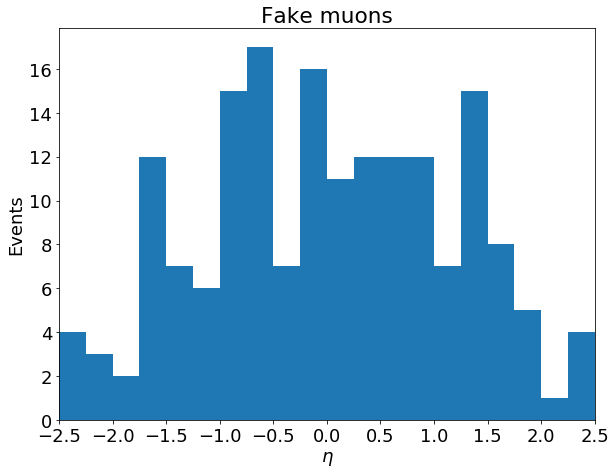

In [28]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_mus_df.fake_eta, bins=np.linspace(-2.5,2.5,21));

plt.title("Fake muons")
plt.xticks(np.linspace(-2.5,2.5,11));
plt.xlabel(r"$\eta$")
plt.ylabel("Events")
axes.margins(x=0) # Remove x-axis margins

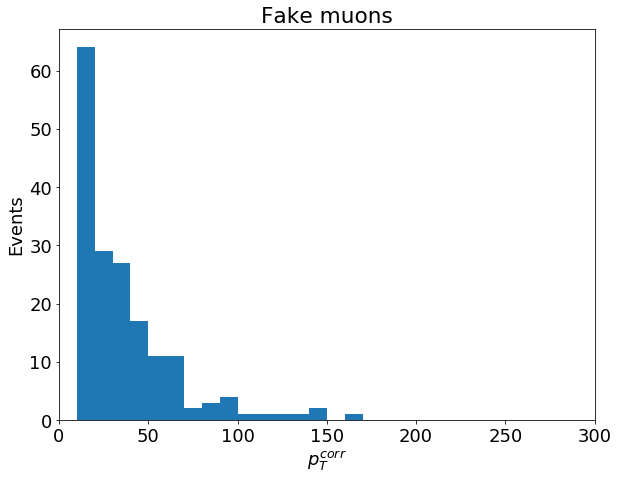

In [29]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_mus_df.fake_pt_corr, bins=np.linspace(0,300,31));

plt.title("Fake muons")
# plt.xticks(np.linspace(-2.5,2.5,11));
plt.xlabel(r"$p_{T}^{corr}$")
plt.ylabel("Events")
axes.margins(x=0) # Remove x-axis margins